In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from pyts.image import GramianAngularField

# Parameters
input_folder = './data'
output_folder = './output/gaf_images/'
n_components = 30  # PCA reduced dimensions
gaf_size = 32       # GAF image size
# max_flows_per_file = 5000  # Change or set to None for full run

# Initialize transformers
scaler = MinMaxScaler()
pca = PCA(n_components=n_components)
gaf = GramianAngularField(method='summation', image_size=gaf_size)

# Create output directory
os.makedirs(output_folder, exist_ok=True)

# Process each CSV file
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
# for csv_file in csv_files:
#     print(f"\n📄 Processing {csv_file}...")
#     df_path = os.path.join(input_folder, csv_file)
#     df = pd.read_csv(df_path)
#     df = df.dropna()
#     print("Unique labels found:", df[' Label'].unique())
#     labels = df[' Label']
#     features = df.replace([np.inf, -np.inf], np.nan).dropna()
#     print("Unique labels found:", labels.unique())


In [2]:
for csv_file in csv_files:
    print(f"\n📄 Processing {csv_file}...")
    df_path = os.path.join(input_folder, csv_file)
    df = pd.read_csv(df_path)
    df.columns = df.columns.str.strip()

    if 'Label' not in df.columns:
        print(f"⚠️ Skipping {csv_file} — 'Label' column not found.")
        continue

    df = df.dropna()
    labels = df['Label'].values
    features = df.select_dtypes(include=[np.number])

    # Remove inf or very large values
    features = features.replace([np.inf, -np.inf], np.nan).dropna()
    features_scaled = scaler.fit_transform(features)
    features_reduced = pca.fit_transform(features_scaled)

    # Prepare output folders
    day_name = os.path.splitext(csv_file)[0]
    day_folder = os.path.join(output_folder, 'by_day', day_name)
    attack_folder = os.path.join(output_folder, 'by_attack_type')
    os.makedirs(day_folder, exist_ok=True)
    os.makedirs(attack_folder, exist_ok=True)

    print(f"Generating GAF images for up to all flows...")

    for idx, (flow, label) in enumerate(zip(features_reduced, labels)):
        try:
            flow_2d = flow.reshape(1, -1)
            gaf.image_size = min(gaf.image_size, flow_2d.shape[1])
            gaf_image = gaf.fit_transform(flow_2d)[0]


            # Save by day
            day_label_folder = os.path.join(day_folder, str(label))
            os.makedirs(day_label_folder, exist_ok=True)
            gaf_day_path = os.path.join(day_label_folder, f"flow_{idx}.png")
            plt.imsave(gaf_day_path, gaf_image, cmap='gray')

            # Save by attack type
            attack_label_folder = os.path.join(attack_folder, str(label))
            os.makedirs(attack_label_folder, exist_ok=True)
            gaf_attack_path = os.path.join(attack_label_folder, f"{day_name}_flow_{idx}.png")
            plt.imsave(gaf_attack_path, gaf_image, cmap='gray')

            # if max_flows_per_file and idx >= max_flows_per_file:
            #     break

        except Exception as e:
            print(f"⚠️ Error on flow {idx}: {e}")
            continue

print("\n✅ GAF image generation complete.")


📄 Processing Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Generating GAF images for up to all flows...

📄 Processing Monday-WorkingHours.pcap_ISCX.csv...
Generating GAF images for up to all flows...

📄 Processing Friday-WorkingHours-Morning.pcap_ISCX.csv...
Generating GAF images for up to all flows...

📄 Processing Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Generating GAF images for up to all flows...

📄 Processing Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Generating GAF images for up to all flows...

📄 Processing Tuesday-WorkingHours.pcap_ISCX.csv...
Generating GAF images for up to all flows...

📄 Processing Wednesday-workingHours.pcap_ISCX.csv...
Generating GAF images for up to all flows...

📄 Processing Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Generating GAF images for up to all flows...

✅ GAF image generation complete.


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob

class GAFDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(image_dir, '*', '*.png'))
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(os.listdir(image_dir)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_name = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_name]

        image = Image.open(image_path).convert('L')  # grayscale
        if self.transform:
            image = self.transform(image)

        return image, label

# Transform and DataLoader
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = GAFDataset(image_dir=os.path.join(output_folder, 'by_attack_type'), transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 15, 15]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 6, 6]
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(dataset.label_map)
model = SimpleCNN(num_classes)


In [ ]:
# GPU/CUDA/MPS Support
import torch

# Check available devices
cuda_available = torch.cuda.is_available()
mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()

print(f"CUDA available: {cuda_available}")
print(f"MPS available: {mps_available}")

# Determine the best device to use
if cuda_available:
    device = torch.device("cuda")
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"Using GPU (CUDA): {device_name}")
    
    # Show memory stats
    print("\nGPU Memory Stats:")
    print(f"Total memory: {torch.cuda.get_device_properties(current_device).total_memory / 1e9:.2f} GB")
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    
    # Optional: Set device settings for faster training
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
elif mps_available:
    device = torch.device("mps")
    print(f"Using GPU (Apple MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU for training (no GPU acceleration available)")

# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")

In [7]:
import torch.optim as optim

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0
    correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc*100:.2f}%")

print("✅ Training complete.")


Using device: mps
Epoch 1, Loss: 4526.4428, Accuracy: 96.95%
Epoch 2, Loss: 4322.4912, Accuracy: 97.04%
Epoch 3, Loss: 4247.3919, Accuracy: 97.11%
Epoch 4, Loss: 4200.7140, Accuracy: 97.16%
Epoch 5, Loss: 4186.7036, Accuracy: 97.18%
✅ Training complete.


In [8]:
# save model
torch.save(model.state_dict(), "cnn_model_weights.pth")


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Set model to evaluation mode
model.eval()

# Lists to collect predictions and true labels
all_preds = []
all_labels = []

# No gradient calculation needed during testing
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# Get sorted label indices and names from dataset.label_map
label_map = dataset.label_map
label_indices = sorted(label_map.values())
label_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

# Classification report and confusion matrix
print("\n📊 Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=label_indices,
    target_names=label_names,
    zero_division=0  # avoids division by zero for missing classes
))




✅ Test Accuracy: 97.25%

📊 Classification Report:
                            precision    recall  f1-score   support

                 .DS_Store       0.00      0.00      0.00         0
                    BENIGN       0.98      0.99      0.98    454300
                       Bot       0.00      0.00      0.00       374
                      DDoS       0.99      1.00      1.00     25462
             DoS GoldenEye       0.40      0.00      0.01      2068
                  DoS Hulk       0.93      0.96      0.95     46009
          DoS Slowhttptest       0.91      0.95      0.93      1093
             DoS slowloris       0.70      0.15      0.24      1108
               FTP-Patator       0.00      0.00      0.00      1531
                Heartbleed       0.00      0.00      0.00         4
              Infiltration       0.00      0.00      0.00         8
                  PortScan       0.94      0.95      0.95     31942
               SSH-Patator       0.00      0.00      0.00      1

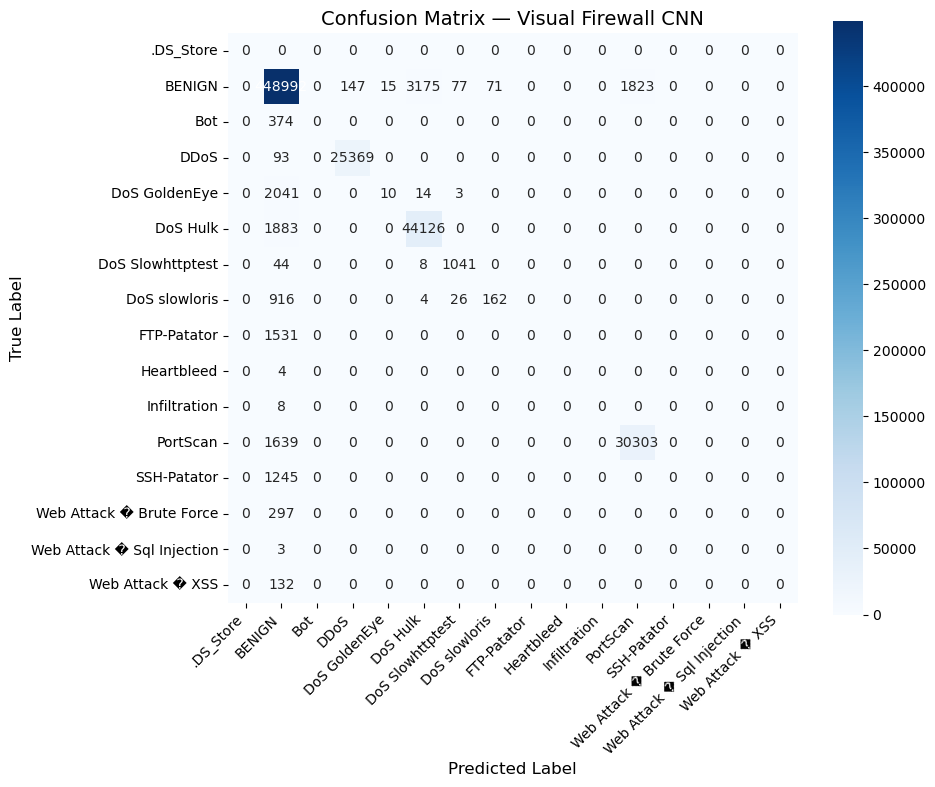

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_indices)

# Set larger figure size based on number of classes
fig_width = max(8, len(label_names) * 0.6)
fig_height = max(6, len(label_names) * 0.5)

plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    cbar=True,
    square=True
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix — Visual Firewall CNN", fontsize=14)

# Rotate x-axis labels for better spacing
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ensure nothing is cut off
plt.tight_layout()

# Optional: Save as image
# plt.savefig("confusion_matrix.png", dpi=300)

plt.show()
